<a href="https://colab.research.google.com/github/ljrn8/quick-notebooks/blob/main/ML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP3010 Machine Learning Assignment | 20757218 Joel Hoefs
Markdown cells are organised based on the criteria given in the assingment description for clarities sake.

## Setup

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn

files = os.listdir('.')
assert files
for f in os.listdir('.'):
  print(f)

.config
test.csv
train.csv
sample_prediction.csv
sample_data


In [162]:
sample_pred = pd.read_csv('sample_prediction.csv', index_col=False)
train = pd.read_csv('train.csv', index_col=False)
test = pd.read_csv('test.csv', index_col=False)
len(train), len(test), len(sample_pred)

(10050, 3203, 3203)

## Preprocessing


#### Identifying and Handling Missing Values
"Examine the dataset for missing or
incomplete entries. Choose appropriate strategies such as imputation or deletion, depending on the context and potential impact on model performance."

In [163]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10050 entries, 0 to 10049
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       10043 non-null  float64
 1   Tank Failure Pressure (bar)      10040 non-null  float64
 2   Liquid Ratio                     10041 non-null  float64
 3   Tank Width (m)                   10043 non-null  float64
 4   Tank Length (m)                  10045 non-null  float64
 5   Tank Height (m)                  10042 non-null  float64
 6   BLEVE Height (m)                 10040 non-null  float64
 7   Vapour Height (m)                10041 non-null  float64
 8   Vapour Temperature (K)           10022 non-null  float64
 9   Liquid Temperature (K)           10022 non-null  float64
 10  Obstacle Distance to BLEVE (m)   10042 non-null  float64
 11  Obstacle Width (m)               10042 non-null  float64
 12  Obstacle Height (m

In [164]:
# The amount of columns with null entries is insignificant -> deletion is appropriate.
train_processed = train.dropna()
print(f'n rows dropped: {len(train) - len(train_processed)}')

n rows dropped: 110


#### Outlier Detection and Treatment
"Detect and address any outliers that may distort your analysis. Apply suitable statistical techniques to correct or exclude these
anomalies."



In [165]:
from scipy import stats

# filter outliers with the Z score method
def filter_outliers(df, cols, threshhold_z=2):
  df_c = df[cols]
  z = stats.zscore(df_c.drop('Status', axis=1))
  non_outliers = abs(z) < threshhold_z
  non_outliers_mask = non_outliers.all(axis=1)
  outliers = len(df_c) - len(df_c[non_outliers_mask])
  rate = outliers / len(df_c)
  print(f'num outliers: {outliers}\noutlier rate: {rate*100} %')

  return non_outliers_mask, df[non_outliers_mask]


non_outliers_mask, filtered = filter_outliers(train_processed, train_processed.columns)


num outliers: 2667
outlier rate: 26.830985915492956 %


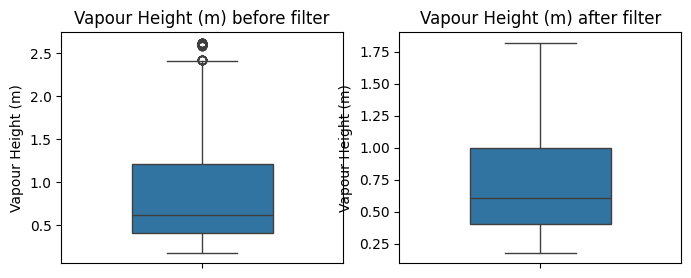

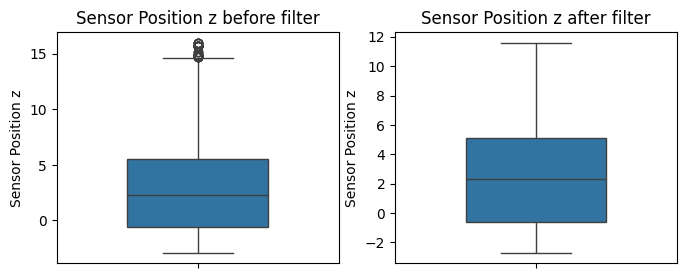

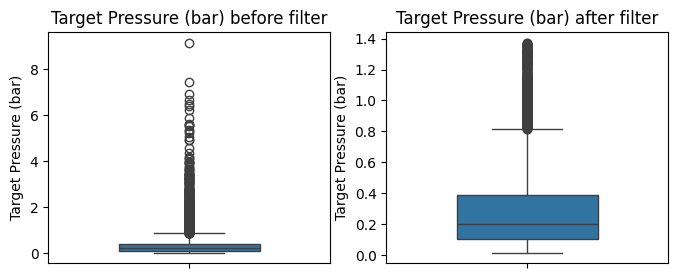

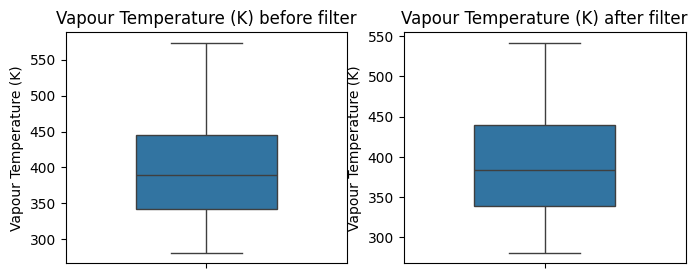

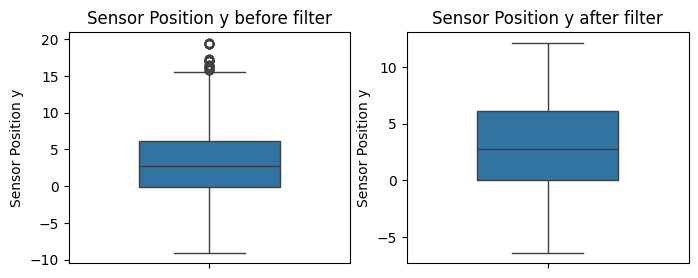

In [166]:
import seaborn as sns

z = stats.zscore(train_processed.drop('Status', axis=1))
outliers = abs(z) > 2
columns = train_processed.drop('Status', axis=1).columns
cols_ranked_by_outliers = sorted(columns, key=lambda c: -outliers[c].sum())

## !!! TODO: dont remove outliers that are appart of the distribution - EG target pressure

# Get a quick idea of the number of outliers ommitted for the columns with most outliers
for c in cols_ranked_by_outliers[:5]:

    plt.figure(figsize=(8, 3))
    ax = plt.subplot(1, 2, 1)
    sns.boxplot(data=train_processed[c], width=0.5, ax=ax)
    ax.set_title(c + ' before filter')

    ax = plt.subplot(1, 2, 2)
    sns.boxplot(data=train_processed[non_outliers_mask][c], width=0.5, ax=ax)
    ax.set_title(c + ' after filter')

    plt.show()

In [167]:
# Target pressure doesnt have outliers, but does have values at z > 2 within its distribution

cols = train_processed.drop('Target Pressure (bar)', axis=1).columns
_, train_processed = filter_outliers(train_processed, cols, 3)

num outliers: 101
outlier rate: 1.016096579476861 %


#### Duplicate Removal
"Ensure dataset integrity by identifying and removing duplicate
records, which can otherwise bias the model."

In [168]:
train_drop_duplicates = train_processed.drop_duplicates()
len(train_drop_duplicates), len(train_processed)

(9789, 9839)

no duplicates found

#### Correcting Inaccurate Entries
"Carefully inspect the data for incorrect values and
rectify them to maintain dataset quality."


In [169]:
train_processed.columns

Index(['Unnamed: 0', 'Tank Failure Pressure (bar)', 'Liquid Ratio',
       'Tank Width (m)', 'Tank Length (m)', 'Tank Height (m)',
       'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)',
       'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)',
       'Obstacle Width (m)', 'Obstacle Height (m)', 'Obstacle Thickness (m)',
       'Obstacle Angle', 'Status', 'Liquid Critical Pressure (bar)',
       'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)',
       'Sensor ID', 'Sensor Position Side', 'Sensor Position x',
       'Sensor Position y', 'Sensor Position z', 'Target Pressure (bar)'],
      dtype='object')

In [170]:
def filter_range(df, c, ub, lb):
  df_filtered = df[(df[c] >= lb) & (df[c] <= ub)]
  n_filtered =  len(df) - len(df_filtered)
  print(f'number of out-of-bounds [{c}] instances = {n_filtered}')
  return df_filtered

# rational metric upperbound for Kelvin/metres
UB = 1_000

filter_range_map = {
  'Tank Failure Pressure (bar)': (0, np.inf),
  'Liquid Ratio': (0, 1),
  'Tank Width (m)': (0, UB),
  'Tank Length (m)': (0, UB),
  'Tank Height (m)': (0, UB),
  'Vapour Height (m)': (0, UB),
  'BLEVE Height (m)': (0, UB),
  'Vapour Temperature (K)': (0, np.inf),
  'Liquid Temperature (K)': (0, UB),
  'Obstacle Distance to BLEVE (m)': (0, UB),
  'Obstacle Width (m)': (0, UB),
  'Obstacle Height (m)': (0, UB),
  'Obstacle Thickness (m)': (0, UB),
  'Obstacle Angle': (0, 30),
  'Sensor ID': (1, 27),
  'Sensor Position Side': (1, 5),
  'Sensor Position x': (-UB, UB),
  'Sensor Position y': (-UB, UB),
  'Sensor Position z': (-UB, UB),
  'Target Pressure (bar)': (0, np.inf),
}

train_interm = train_processed.copy()
for column, (lb, ub) in filter_range_map.items():
  train_interm = filter_range(train_interm, column, ub, lb)


number of out-of-bounds [Tank Failure Pressure (bar)] instances = 0
number of out-of-bounds [Liquid Ratio] instances = 0
number of out-of-bounds [Tank Width (m)] instances = 0
number of out-of-bounds [Tank Length (m)] instances = 0
number of out-of-bounds [Tank Height (m)] instances = 0
number of out-of-bounds [Vapour Height (m)] instances = 0
number of out-of-bounds [BLEVE Height (m)] instances = 149
number of out-of-bounds [Vapour Temperature (K)] instances = 0
number of out-of-bounds [Liquid Temperature (K)] instances = 0
number of out-of-bounds [Obstacle Distance to BLEVE (m)] instances = 0
number of out-of-bounds [Obstacle Width (m)] instances = 0
number of out-of-bounds [Obstacle Height (m)] instances = 0
number of out-of-bounds [Obstacle Thickness (m)] instances = 0
number of out-of-bounds [Obstacle Angle] instances = 0
number of out-of-bounds [Sensor ID] instances = 0
number of out-of-bounds [Sensor Position Side] instances = 0
number of out-of-bounds [Sensor Position x] instan

All columns adhered to the required range, except 'BLEVE Height (m)'

(-0.05, 0.3)

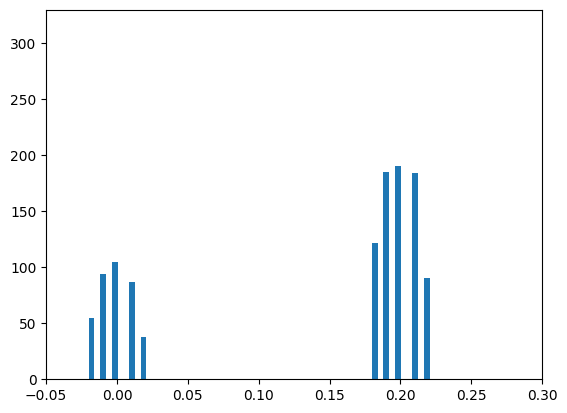

In [171]:
plt.hist(train_processed['BLEVE Height (m)'], bins=500)
plt.xlim(-0.05, 0.3)

some BlEVE Height measurements where negative, and given their proximity to 0, I will simply round up.

In [172]:
train_processed['BLEVE Height (m)'] = train_processed['BLEVE Height (m)'].map(lambda x: max(x, 0))

In [173]:
# ensure no incorrect categorical/ordinal entries:
for c in ('Status', 'Sensor Position Side', 'Sensor ID'):
  print(c + ' unique values: ')
  print(np.unique(train_processed[c]))
  print()

Status unique values: 
['Saperheated' 'Subcoled' 'Subcool' 'Subcooled' 'Superheat' 'Superheated'
 'subcooled' 'superheated']

Sensor Position Side unique values: 
[1. 2. 3. 4. 5.]

Sensor ID unique values: 
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27.]



'Status' entries should be either 'subcooled' or 'superheated'

In [174]:
def status_map(name):
  if name in ['Saperheated', 'Superheat', 'Superheated', 'superheated']:
    return 'superheated'
  else:
    return 'subcooled'

train_processed['Status'] = train_processed['Status'].map(status_map)
np.unique(train_processed['Status'])

array(['subcooled', 'superheated'], dtype=object)

#### Feature Selection
"Identify and retain only the features that exhibit meaningful correlation with the target variable. Consider building a “sparse” model using a reduced
set of the most informative features"

In [175]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9839 entries, 0 to 10049
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       9839 non-null   float64
 1   Tank Failure Pressure (bar)      9839 non-null   float64
 2   Liquid Ratio                     9839 non-null   float64
 3   Tank Width (m)                   9839 non-null   float64
 4   Tank Length (m)                  9839 non-null   float64
 5   Tank Height (m)                  9839 non-null   float64
 6   BLEVE Height (m)                 9839 non-null   float64
 7   Vapour Height (m)                9839 non-null   float64
 8   Vapour Temperature (K)           9839 non-null   float64
 9   Liquid Temperature (K)           9839 non-null   float64
 10  Obstacle Distance to BLEVE (m)   9839 non-null   float64
 11  Obstacle Width (m)               9839 non-null   float64
 12  Obstacle Height (m)     

In [176]:
from sklearn.ensemble import RandomForestRegressor

# use a random forest to capture feature importances
rf = RandomForestRegressor()
X = train_processed.drop('Target Pressure (bar)', axis=1)
y = train_processed['Target Pressure (bar)']
X['Status'] = X['Status'].map({"superheated": 0, "subcooled": 1})

rf.fit(X, y)
importances = rf.feature_importances_
print(importances)

[0.01606396 0.04728661 0.01195768 0.02548656 0.11832663 0.01694008
 0.0128618  0.13554028 0.0116077  0.01658299 0.04368871 0.00801244
 0.00495677 0.0145967  0.00664209 0.00092963 0.00066721 0.00093418
 0.00090495 0.22423533 0.06678155 0.09249345 0.03646223 0.0860405 ]


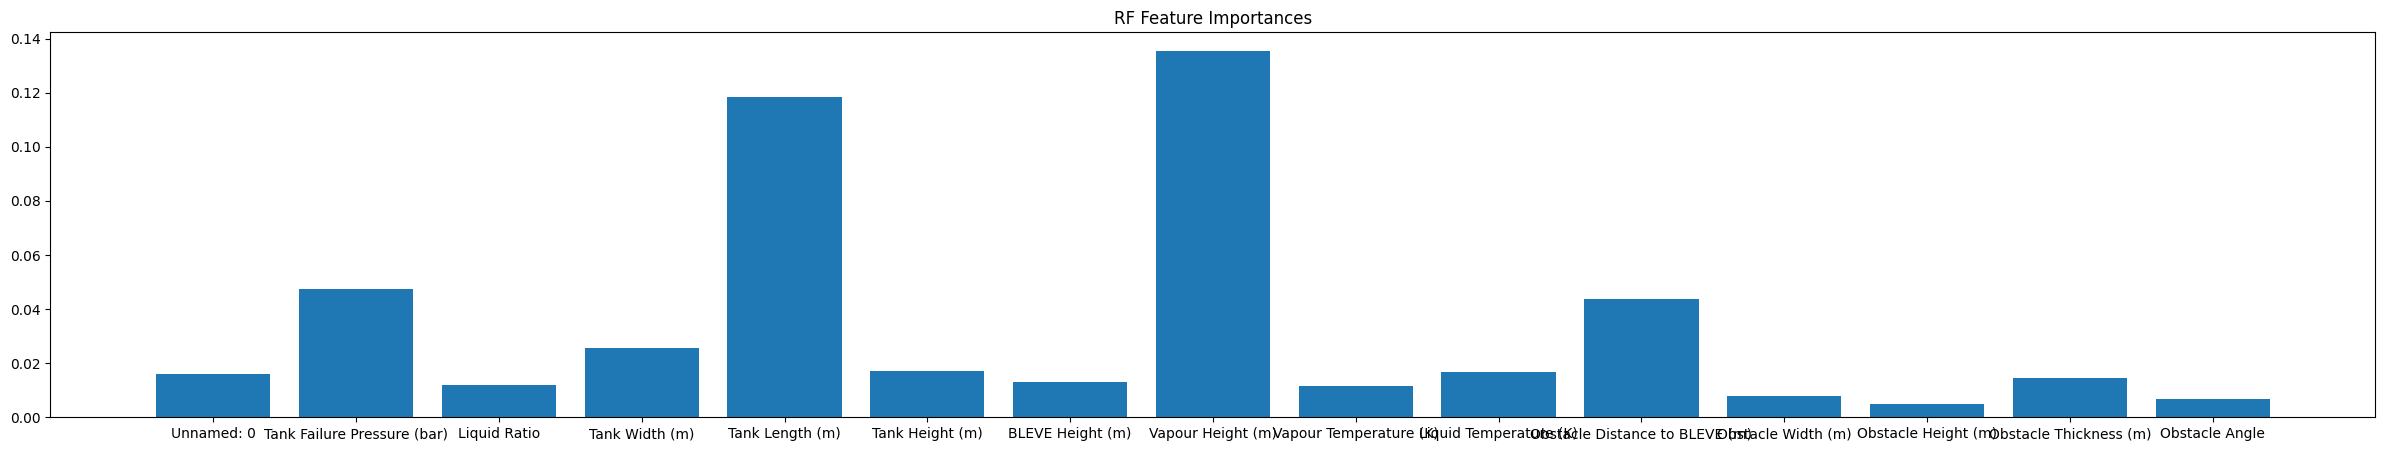

<BarContainer object of 9 artists>

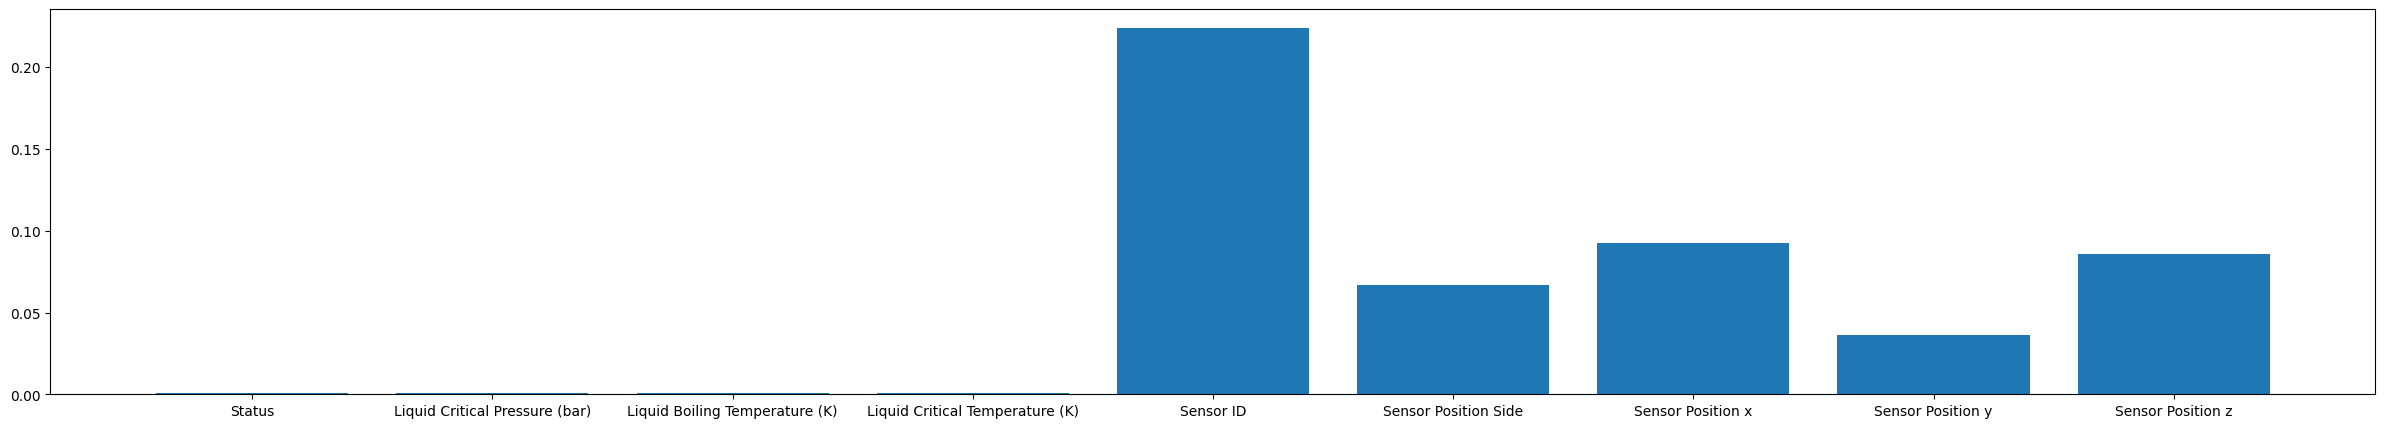

In [177]:
plt.figure(figsize=(30, 5))
plt.bar(X.columns[:15], importances[:15])
plt.title('RF Feature Importances')
plt.show()

plt.figure(figsize=(30, 5))
plt.bar(X.columns[15:], importances[15:])

In [178]:
selected_features = [X.columns[i] for i in importances.argsort()[4:]]  # remove bottom 4 features
selected_features

['Obstacle Height (m)',
 'Obstacle Angle',
 'Obstacle Width (m)',
 'Vapour Temperature (K)',
 'Liquid Ratio',
 'BLEVE Height (m)',
 'Obstacle Thickness (m)',
 'Unnamed: 0',
 'Liquid Temperature (K)',
 'Tank Height (m)',
 'Tank Width (m)',
 'Sensor Position y',
 'Obstacle Distance to BLEVE (m)',
 'Tank Failure Pressure (bar)',
 'Sensor Position Side',
 'Sensor Position z',
 'Sensor Position x',
 'Tank Length (m)',
 'Vapour Height (m)',
 'Sensor ID']

In [179]:
train_processed = train_processed[selected_features + ['Target Pressure (bar)']]

#### Feature Engineering
"You are encouraged to derive new features that could improve
model performance. For instance, the ratio Tank Width
Tank Length may serve as a useful additional
feature."

In [180]:
train_processed.columns

Index(['Obstacle Height (m)', 'Obstacle Angle', 'Obstacle Width (m)',
       'Vapour Temperature (K)', 'Liquid Ratio', 'BLEVE Height (m)',
       'Obstacle Thickness (m)', 'Unnamed: 0', 'Liquid Temperature (K)',
       'Tank Height (m)', 'Tank Width (m)', 'Sensor Position y',
       'Obstacle Distance to BLEVE (m)', 'Tank Failure Pressure (bar)',
       'Sensor Position Side', 'Sensor Position z', 'Sensor Position x',
       'Tank Length (m)', 'Vapour Height (m)', 'Sensor ID',
       'Target Pressure (bar)'],
      dtype='object')

In [181]:
import seaborn as sns

# sns.pairplot(train_processed)
# ^^ was used to observe directly correlated features, too large to uncomment

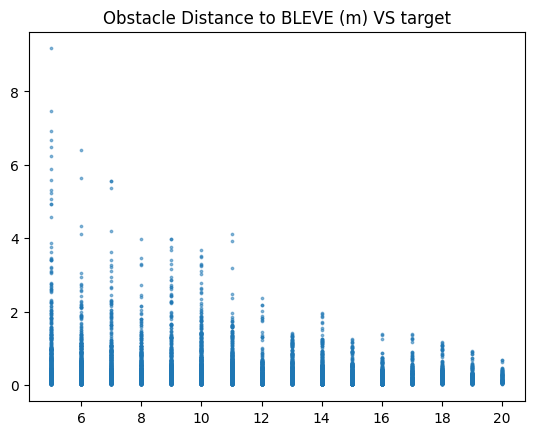

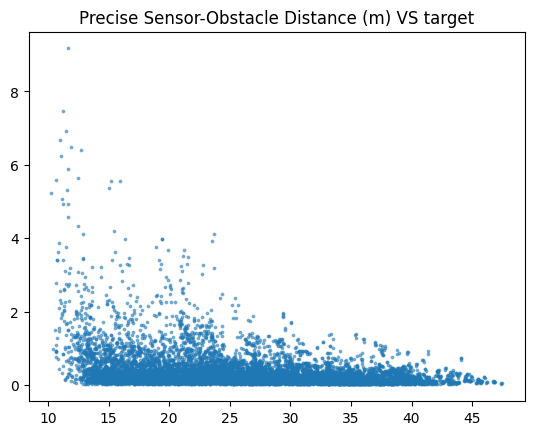

In [182]:
# Dimension Ratio's
train_processed['Tank width/length Ratio'] = train_processed['Tank Width (m)'] / train_processed['Tank Length (m)']
train_processed['Tank width/height Ratio'] =  train_processed['Tank Width (m)'] / train_processed['Tank Height (m)']

# precise distance to sensor
sensor_offsets = np.sqrt(train_processed['Sensor Position x']**2 + train_processed['Sensor Position y']**2 + train_processed['Sensor Position z']**2)
train_processed['Sensor-Obstacle Distance'] = train_processed['Obstacle Distance to BLEVE (m)'] + sensor_offsets

plt.scatter(train_processed['Obstacle Distance to BLEVE (m)'], train_processed['Target Pressure (bar)'], s=3, alpha=0.5);
plt.title('Obstacle Distance to BLEVE (m) VS target')
plt.show()
plt.scatter(train_processed['Sensor-Obstacle Distance'], train_processed['Target Pressure (bar)'], s=3, alpha=0.5)
plt.title('Precise Sensor-Obstacle Distance (m) VS target')
plt.show()

Adding the sensor possition offset of the obsticle to the BLEVE distance logically better correlates with the target pressure

#### Data Type Conversion
"Convert features to appropriate data types as required by
your model. For example, categorical variables may need to be encoded into numerical
formats using one-hot encoding or similar techniques"

In [184]:
# train_processed = train_processed['Status'].map({"superheated": 0, "subcooled": 1})
# 'Status' was removed during feature selection, all features are numerical

## Model Developement

In [224]:
from sklearn.model_selection import train_test_split

X, y = train_processed.drop('Target Pressure (bar)', axis=1), train_processed['Target Pressure (bar)']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=0)

for d in X_train, X_valid, y_train, y_valid:
  print(len(d), end='\t')

7871	1968	7871	1968	

#### Model Selection

In [232]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

for (model, name) in ((xgb.XGBRegressor(), 'XGboost'),
                      (RandomForestRegressor(), 'RF'),
                      (SVR(), 'SVM'),
                      (LinearRegression(), 'LR')):

  model.fit(X_train, y_train)
  y_pred = model.predict(X_valid)

  print('\n' + name)
  print('MAPE: ',  mean_absolute_percentage_error(y_valid, y_pred))
  print('R2: ', r2_score(y_valid, y_pred))


XGboost
MAPE:  0.2255071280910732
R2:  0.8971646504538948

RF
MAPE:  0.20540906942199066
R2:  0.8938594580524444

SVM
MAPE:  1.0739683423261839
R2:  -0.0664181960578174

Lr
MAPE:  1.2822724778934191
R2:  0.4711742470994644


In [234]:
X_train.shape

(7871, 23)

In [287]:
import torch
import torch.nn as nn

class NN(nn.Module):
  def __init__(self, input_size, hidden_layers):
    super(NN, self).__init__()

    layers = []
    layers.append(nn.Linear(input_size, hidden_layers[0]))
    layers.append(nn.ReLU())

    for i in range(1, len(hidden_layers)):
      layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
      layers.append(nn.ReLU())

    layers.append(nn.Linear(hidden_layers[-1], 1))
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

In [303]:
from sklearn.preprocessing import StandardScaler

# redo train-validation split with standradization

X, y = train_processed.drop('Target Pressure (bar)', axis=1), train_processed['Target Pressure (bar)']
ss = StandardScaler()
X = ss.fit_transform(X)

# conv to torch tensors
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)


X_train, X_valid, y_train, y_valid = train_test_split(
    X_torch, y_torch, test_size=0.2, random_state=0)

In [313]:
import torch.optim as optim

def train_nn(epochs, input_size, hidden_layers, lr, eval_n=3):
  model = NN(input_size, hidden_layers)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  R2, MAPE = [], []

  for epoch in range(epochs):
    optimizer.zero_grad()

    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if epoch % (epochs // eval_n) == 0 or epoch == epochs - 1:
      print(f"Epoch {epoch}/{epochs}: loss {loss}")

      y_pred = model(X_valid)
      y_v, y_p = y_valid.detach().numpy(), y_pred.detach().numpy()
      mape =  mean_absolute_percentage_error(y_v, y_p)
      r2 = r2_score(y_v, y_p)
      print('MAPE: ', mape)
      print('R2: ', r2)

      R2.append(r2)
      MAPE.append(mape)


  return model, R2, MAPE

model, R2, MAPE = train_nn(epochs=500, input_size=23, hidden_layers=(64, 32), lr=0.005)

Epoch 0/500: loss 0.3443070948123932
MAPE:  1.4660886526107788
R2:  -0.09267675876617432
Epoch 166/500: loss 0.0063484744168818
MAPE:  0.26687052845954895
R2:  0.9481868147850037
Epoch 332/500: loss 0.0031767573673278093
MAPE:  0.2296421378850937
R2:  0.9553937911987305
Epoch 498/500: loss 0.0022758934646844864
MAPE:  0.2158326953649521
R2:  0.9606970548629761
Epoch 499/500: loss 0.0022313192021101713
MAPE:  0.2174024134874344
R2:  0.9619508981704712


#### Hyperparameter Tuning

##### Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 30],
    'min_samples_leaf': [1, 2, 4],
    # 'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_valid)

In [327]:
MAPE = mean_absolute_percentage_error(y_valid, y_pred)
print("Best HPs:", grid_search.best_params_)
print(f"MAPE: {MAPE}")

Best HPs: {'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 150}
MAPE: 0.20901569501806797


##### Nueral Network

In [293]:
model = train_nn(epochs=500, input_size=23, hidden_layers=(128, 64, 32), lr=0.005)

Epoch 0/500: loss 0.27868109941482544
Epoch 166/500: loss 0.005965815857052803
Epoch 332/500: loss 0.0019176838686689734
Epoch 498/500: loss 0.0013417963637039065
MAPE:  0.17713335156440735
R2:  0.9656121730804443


In [305]:
# see were it overfits
model, R2, MAPE = train_nn(epochs=1_000, input_size=23, hidden_layers=(128, 64, 32), lr=0.005, eval_n=50)

Epoch 0/1000: loss 0.36527204513549805
MAPE:  0.7555569410324097
R2:  -0.23121201992034912
Epoch 20/1000: loss 0.12580958008766174
MAPE:  0.8732240796089172
R2:  0.4984637498855591
Epoch 40/1000: loss 0.03369741514325142
MAPE:  0.38808080554008484
R2:  0.8544047474861145
Epoch 60/1000: loss 0.013768845237791538
MAPE:  0.2947407364845276
R2:  0.9354177713394165
Epoch 80/1000: loss 0.01134139858186245
MAPE:  0.28236663341522217
R2:  0.9196077585220337
Epoch 100/1000: loss 0.006588400807231665
MAPE:  0.2689301073551178
R2:  0.9461027383804321
Epoch 120/1000: loss 0.005453568417578936
MAPE:  0.2552173137664795
R2:  0.9521623849868774
Epoch 140/1000: loss 0.004725311417132616
MAPE:  0.24067609012126923
R2:  0.9506646990776062
Epoch 160/1000: loss 0.004480396397411823
MAPE:  0.23019328713417053
R2:  0.9535375833511353
Epoch 180/1000: loss 0.004883816931396723
MAPE:  0.2231757640838623
R2:  0.9459589123725891
Epoch 200/1000: loss 0.003536246018484235
MAPE:  0.21648277342319489
R2:  0.95923620

Overfits at epoch ~600

In [315]:
from tqdm import tqdm

# instead of grid search or random search, Im only looking at a few logical hyper parameter configurations

results = []
for HP in (
      ((128, 64, 32), 0.005, 600), # medium
      ((64, 32), 0.01, 300),      # small
      ((64, 32, 16), 0.01, 300),   # small and long
      ((256, 128, 64, 32), 0.001, 800) # big
):

  layers, lr, epochs = HP
  model, R2, MAPE = train_nn(epochs=epochs, input_size=23, hidden_layers=layers, lr=lr, eval_n=1)
  results.append((HP, (model, R2[-1], MAPE[-1])))

results

Epoch 0/600: loss 0.4871892035007477
MAPE:  0.8509512543678284
R2:  -0.48129212856292725
Epoch 599/600: loss 0.001228502718731761
MAPE:  0.1766495704650879
R2:  0.969031572341919
Epoch 0/300: loss 0.32576632499694824
MAPE:  2.121631145477295
R2:  -0.05091583728790283
Epoch 299/300: loss 0.00292626628652215
MAPE:  0.22974923253059387
R2:  0.958568811416626
Epoch 0/300: loss 0.41742396354675293
MAPE:  0.6660557389259338
R2:  -0.17619264125823975
Epoch 299/300: loss 0.004678789526224136
MAPE:  0.21165971457958221
R2:  0.9518678784370422
Epoch 0/800: loss 0.40702688694000244
MAPE:  1.0341534614562988
R2:  -0.5474159717559814
Epoch 799/800: loss 0.0008621992892585695
MAPE:  0.1629536747932434
R2:  0.9657692313194275


[(((128, 64, 32), 0.005, 600),
  (NN(
     (model): Sequential(
       (0): Linear(in_features=23, out_features=128, bias=True)
       (1): ReLU()
       (2): Linear(in_features=128, out_features=64, bias=True)
       (3): ReLU()
       (4): Linear(in_features=64, out_features=32, bias=True)
       (5): ReLU()
       (6): Linear(in_features=32, out_features=1, bias=True)
     )
   ),
   0.969031572341919,
   0.1766495704650879)),
 (((64, 32), 0.01, 300),
  (NN(
     (model): Sequential(
       (0): Linear(in_features=23, out_features=64, bias=True)
       (1): ReLU()
       (2): Linear(in_features=64, out_features=32, bias=True)
       (3): ReLU()
       (4): Linear(in_features=32, out_features=1, bias=True)
     )
   ),
   0.958568811416626,
   0.22974923253059387)),
 (((64, 32, 16), 0.01, 300),
  (NN(
     (model): Sequential(
       (0): Linear(in_features=23, out_features=64, bias=True)
       (1): ReLU()
       (2): Linear(in_features=64, out_features=32, bias=True)
       (3): Re

In [320]:
# best model was
model, r2, mape = results[-1][1]
model

NN(
  (model): Sequential(
    (0): Linear(in_features=23, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [323]:
# results
print('r2 score:', r2)
print('MAPE score:', mape)

r2 score: 0.9657692313194275
MAPE score: 0.1629536747932434


# TODO
- learning curves
- optimize XGBoost
- Kaggle submittion
- should have used cross validation
